<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Exam_preparation/Time_series_forecasting_sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import helper functions file
!wget https://raw.githubusercontent.com/schauppi/Udemy_TensorFlow_Developer/main/Exam_preparation/helper_functions.py

In [30]:
#Import functions from helper file
from helper_functions import make_windows
from helper_functions import make_train_test_splits
from helper_functions import make_preds
from helper_functions import evaluate_preds

## Load and Prepare Data

In [1]:
#Download and import Dataset
!wget https://raw.githubusercontent.com/schauppi/Udemy_TensorFlow_Developer/main/Exam_preparation/Datasets/Sunspots.csv

--2021-09-04 07:20:40--  https://raw.githubusercontent.com/schauppi/Udemy_TensorFlow_Developer/main/Exam_preparation/Datasets/Sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68195 (67K) [text/plain]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  66.60K  --.-KB/s    in 0.01s   

2021-09-04 07:20:40 (5.69 MB/s) - ‘Sunspots.csv’ saved [68195/68195]



In [3]:
#Import dataset
import pandas as pd
df = pd.read_csv("/content/Sunspots.csv", index_col=["Date"])
df.head()

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3265 entries, 1749-01-31 to 2021-01-31
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 76.5+ KB


In [5]:
len(df)

3265

In [18]:
#Drop unnamed column and only use the "Monthly Mean Total Sunspot Number"
sunspots_data = pd.DataFrame(df["Monthly Mean Total Sunspot Number"]).rename(columns={"Monthly Mean Total Sunspot Number": "Sunspots"})
sunspots_data.head()

,Sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


Text(0, 0.5, 'Sunspots')

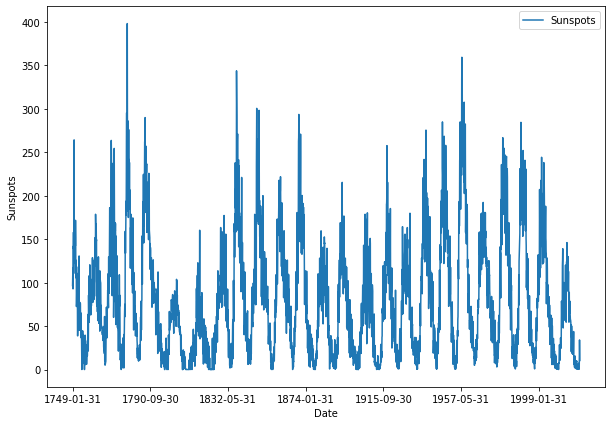

In [19]:
#Plot sunspot data
import matplotlib.pyplot as plt
sunspots_data.plot(figsize=(10, 7))
plt.ylabel("Sunspots")

In [20]:
#Get ETH price and date in numpy array
timesteps = sunspots_data.index.to_numpy()
sunspots = sunspots_data["Sunspots"].to_numpy()
timesteps[:10], prices[:10]

(array(['1749-01-31', '1749-02-28', '1749-03-31', '1749-04-30',
        '1749-05-31', '1749-06-30', '1749-07-31', '1749-08-31',
        '1749-09-30', '1749-10-31'], dtype=object),
 array([ 96.7, 104.3, 116.7,  92.8, 141.7, 139.2, 158. , 110.5, 126.5,
        125.8]))

In [21]:
#Reshape data for rescaling
sunspots = sunspots.reshape(-1, 1)
print(sunspots.shape)
print(sunspots[:10])

(3265, 1)
[[ 96.7]
 [104.3]
 [116.7]
 [ 92.8]
 [141.7]
 [139.2]
 [158. ]
 [110.5]
 [126.5]
 [125.8]]


## Normalize Data

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_sunspots = scaler.fit_transform(sunspots)
scaled_sunspots[:10]

array([[0.24284279],
       [0.26192868],
       [0.29306881],
       [0.23304872],
       [0.35585133],
       [0.34957308],
       [0.39678553],
       [0.27749874],
       [0.31767956],
       [0.31592165]])

In [23]:
#Reshape data for windowing and plotting
import numpy as np
scaled_sunspots = np.squeeze(scaled_sunspots, axis=1)
print(scaled_sunspots[:10])
print(scaled_sunspots.shape)

[0.24284279 0.26192868 0.29306881 0.23304872 0.35585133 0.34957308
 0.39678553 0.27749874 0.31767956 0.31592165]
(3265,)


In [24]:
#Is data between 0 and 1
print(f"Max value in array: {np.max(scaled_sunspots)}")
print(f"Min value in array: {np.min(scaled_sunspots)}")

Max value in array: 1.0
Min value in array: 0.0


Text(0, 0.5, 'Sunspots')

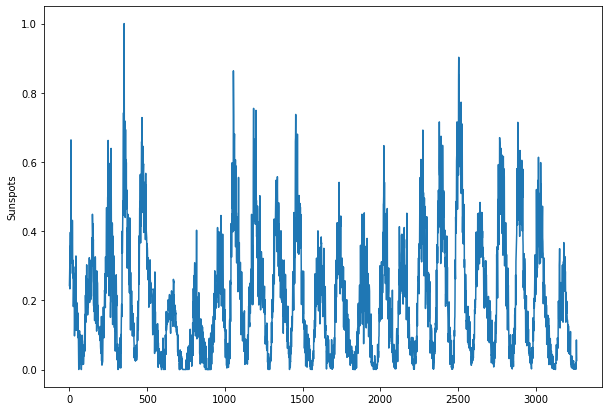

In [27]:
#Check graphical if data is between 0 and 1
plt.figure(figsize=(10,7))
plt.plot(scaled_sunspots)
plt.ylabel("Sunspots")

## Dataset preparation

In [31]:
#Window dataset with different window sizes
windows_5, labels_5 = make_windows(scaled_sunspots, window_size=5, horizon=1)
windows_7, labels_7 = make_windows(scaled_sunspots, window_size=7, horizon=1)
windows_10, labels_10 = make_windows(scaled_sunspots, window_size=10, horizon=1)

In [32]:
#Make train and test split from windowed data
train_windows_5, test_windows_5, train_labels_5, test_labels_5 = make_train_test_splits(windows_5, labels_5)
train_windows_7, test_windows_7, train_labels_7, test_labels_7 = make_train_test_splits(windows_7, labels_7)
train_windows_10, test_windows_10, train_labels_10, test_labels_10 = make_train_test_splits(windows_10, labels_10)

## Modelling experiments


### Model 1: Dense w5h1

In [160]:
import tensorflow as tf
from tensorflow.keras import layers

window_size = 5
horizon=1

tf.random.set_seed(42)

#Build the model 
inputs = layers.Input(shape=window_size)
x = layers.Dense(128, activation="relu")(inputs)
outputs = layers.Dense(horizon)(x)
model_1 = tf.keras.Model(inputs, outputs)

In [161]:
#Compile the model 
model_1.compile(loss="mae", optimizer="Adam", metrics=["mae","mse"])

In [162]:
#Fit the model 
history_model_1 = model_1.fit(train_windows_5, train_labels_5,
                              epochs=500,
                              batch_size=128,
                              verbose=0,
                              validation_data = (test_windows_5, test_labels_5),
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=0),
                                         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

In [163]:
model_1.evaluate(test_windows_5, test_labels_5)

21/21 [==============================] - 0s 1ms/step - loss: 0.0421 - mae: 0.0421 - mse: 0.0034


[0.042074065655469894, 0.042074065655469894, 0.0033770266454666853]

In [164]:
#Make predictions
model_1_preds = make_preds(model_1, test_windows_5)
model_1_results = evaluate_preds(tf.squeeze(test_labels_5),model_1_preds)
model_1_results

{'mae': 0.042074073,
 'mape': 19098.406,
 'mse': 0.0033770269,
 'rmse': 0.058112193}

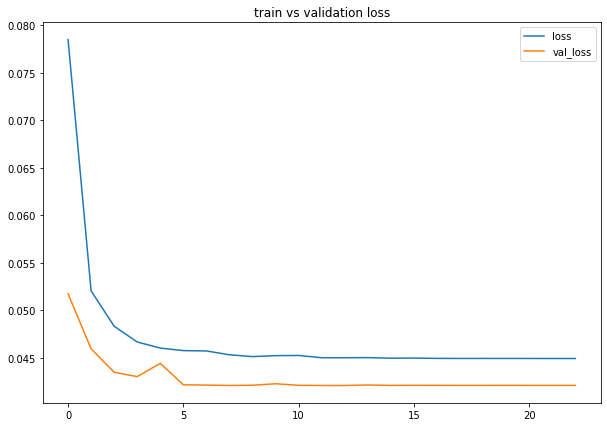

In [165]:
# Plot training curve
loss = history_model_1.history["loss"]
val_loss = history_model_1.history["val_loss"]

plt.figure(figsize=(10, 7))
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.title("train vs validation loss")
plt.legend()

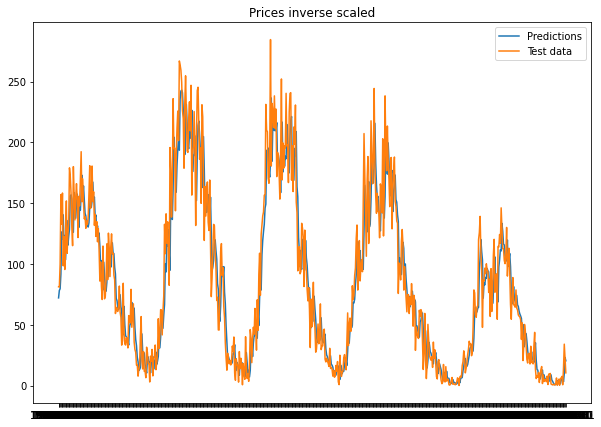

In [166]:
model_1_preds = model_1_preds.numpy()
model_1_preds = model_1_preds.reshape(-1, 1)
model_1_preds_rescaled = scaler.inverse_transform(model_1_preds)
plt.figure(figsize=(10,7))
plt.plot(timesteps[int(len(timesteps)) - int(len(test_labels_5)):].tolist(), model_1_preds_rescaled.tolist(),label="Predictions")
plt.plot(timesteps[int(len(timesteps)) - int(len(test_labels_5)):].tolist(), sunspots[int(len(timesteps)) - int(len(test_labels_5)):].tolist(), label="Test data")
plt.title("Prices inverse scaled")
plt.legend()

### Model 2: LSTM w5h1

In [227]:
window_size = 5
horizon=1

tf.random.set_seed(42)

#Build the model 
inputs = layers.Input(shape=(window_size))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="tanh", return_sequences=True)(x)
x = layers.LSTM(64, activation="tanh", return_sequences=True)(x)
x = layers.LSTM(32, activation="tanh")(x)
outputs = layers.Dense(horizon)(x)
model_2 = tf.keras.Model(inputs, outputs)

In [228]:
#Compile the model 
model_2.compile(loss="mae", optimizer="Adam", metrics=["mse", "mae"])

In [229]:
#Fit the model 
history_model_2 = model_2.fit(train_windows_5, train_labels_5,
                              epochs=500, 
                              batch_size=256,
                              verbose=0,
                              validation_data=(test_windows_5, test_labels_5), 
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=0),
                                         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

In [230]:
#Evaluate
model_2.evaluate(test_windows_5, test_labels_5)

21/21 [==============================] - 0s 3ms/step - loss: 0.0420 - mse: 0.0034 - mae: 0.0420


[0.04196461662650108, 0.0033620763570070267, 0.04196461662650108]

In [231]:
#Make predictions
model_2_preds = make_preds(model_2, test_windows_5)
model_2_results = evaluate_preds(tf.squeeze(test_labels_5),model_2_preds)
model_2_results

{'mae': 0.041964613,
 'mape': 17440.145,
 'mse': 0.0033620761,
 'rmse': 0.057983413}

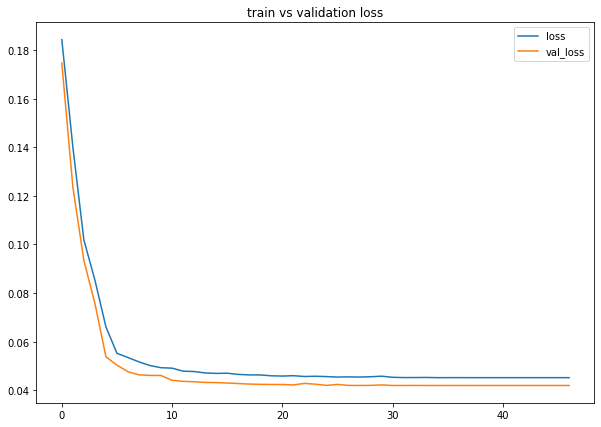

In [232]:
# Plot training curve
loss = history_model_2.history["loss"]
val_loss = history_model_2.history["val_loss"]

plt.figure(figsize=(10, 7))
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.title("train vs validation loss")
plt.legend()

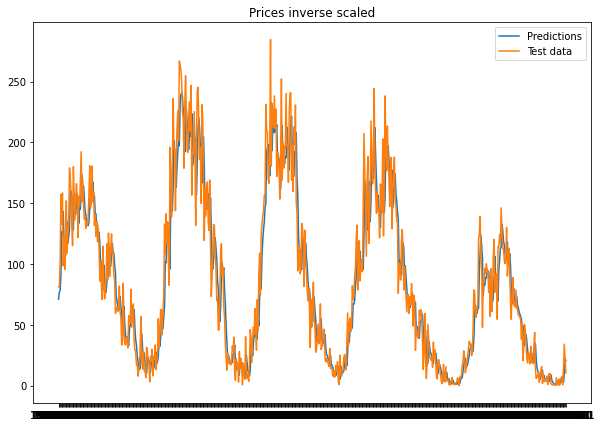

In [233]:
model_2_preds = model_2_preds.numpy()
model_2_preds = model_2_preds.reshape(-1, 1)
model_2_preds_rescaled = scaler.inverse_transform(model_2_preds)
plt.figure(figsize=(10,7))
plt.plot(timesteps[int(len(timesteps)) - int(len(test_labels_5)):].tolist(), model_2_preds_rescaled.tolist(),label="Predictions")
plt.plot(timesteps[int(len(timesteps)) - int(len(test_labels_5)):].tolist(), sunspots[int(len(timesteps)) - int(len(test_labels_5)):].tolist(), label="Test data")
plt.title("Prices inverse scaled")
plt.legend()

### Model 3: Bi-LSTM w5h1

In [270]:
window_size = 5
horizon = 1

tf.random.set_seed(42)

#Build the model
inputs = layers.Input(shape=(window_size))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.Bidirectional(layers.LSTM(256, activation="tanh", return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128, activation="tanh", return_sequences=True))(x)
outputs = layers.Dense(horizon)(x)
model_3 = tf.keras.Model(inputs, outputs)

In [271]:
#Compile the model 
model_3.compile(loss="mae", metrics=["mae", "mse"], optimizer="Adam")

In [272]:
#Fit the model 
history_model_3 = model_3.fit(train_windows_5, train_labels_5,
                              epochs=500,
                              batch_size=128,
                              verbose=0,
                              validation_data=(test_windows_5, test_labels_5),
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=0),
                                         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)])

In [273]:
#Evaluate
model_3.evaluate(test_windows_5, test_labels_5)

21/21 [==============================] - 0s 7ms/step - loss: 0.0420 - mae: 0.0420 - mse: 0.0033


[0.041953008621931076, 0.041953008621931076, 0.0033492925576865673]

In [274]:
#Make predictions
model_3_preds = make_preds(model_3, test_windows_5)
model_3_results = evaluate_preds(tf.squeeze(test_labels_5),model_3_preds)
model_3_results

{'mae': 0.041953012,
 'mape': 17872.842,
 'mse': 0.0033492928,
 'rmse': 0.057873074}

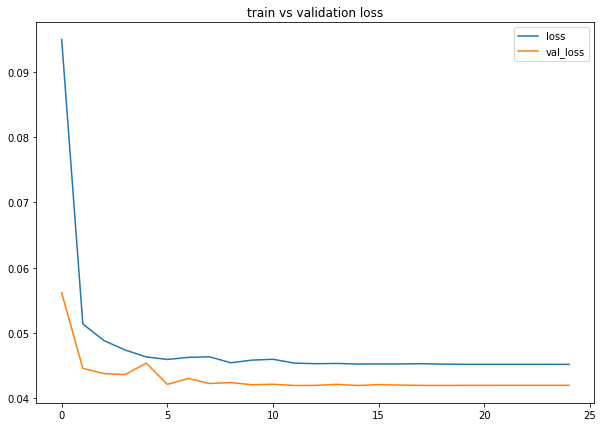

In [275]:
# Plot training curve
loss = history_model_3.history["loss"]
val_loss = history_model_3.history["val_loss"]

plt.figure(figsize=(10, 7))
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.title("train vs validation loss")
plt.legend()

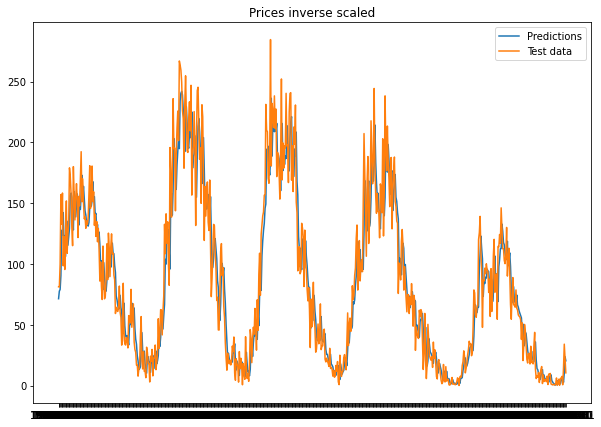

In [276]:
model_3_preds = model_3_preds.numpy()
model_3_preds = model_3_preds.reshape(-1, 1)
model_3_preds_rescaled = scaler.inverse_transform(model_3_preds)
plt.figure(figsize=(10,7))
plt.plot(timesteps[int(len(timesteps)) - int(len(test_labels_5)):].tolist(), model_3_preds_rescaled.tolist(),label="Predictions")
plt.plot(timesteps[int(len(timesteps)) - int(len(test_labels_5)):].tolist(), sunspots[int(len(timesteps)) - int(len(test_labels_5)):].tolist(), label="Test data")
plt.title("Prices inverse scaled")
plt.legend()